In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2
from tqdm import tqdm

import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers, models
from tensorflow.keras.applications import EfficientNetB3
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

2025-04-13 08:09:42.507349: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1744531782.530445    5181 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1744531782.537247    5181 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
import pandas as pd

path = "/kaggle/input/aptos2019-blindness-detection"

train_df = pd.read_csv(f"{path}/train.csv")
test_df = pd.read_csv(f"{path}/test.csv")

# Prepare image filenames and labels
train_df["diagnosis"] = train_df["diagnosis"].astype(str)
train_df["id_code"] = train_df["id_code"] + ".png"

print(f"Training samples: {len(train_df)}")
print(f"Testing samples: {len(test_df)}")

Training samples: 3662
Testing samples: 1928


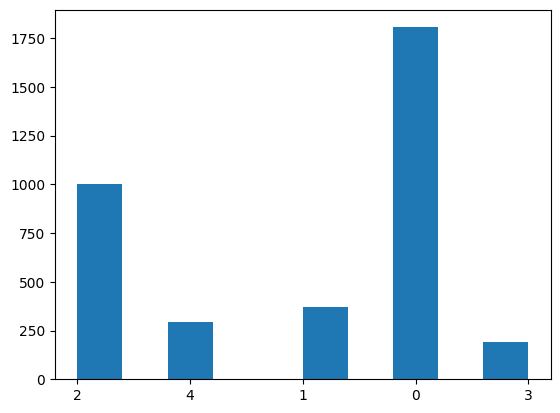

In [3]:
train_df.diagnosis.hist()
plt.xticks([0,1,2,3,4])
plt.grid(False)
plt.show() 

In [4]:
import os
import cv2
import numpy as np
from tqdm import tqdm
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Setup
img_size = 512
input_dir = f"{path}/train_images/"
output_dir = "/kaggle/working/augmented_balanced_train/"
os.makedirs(output_dir, exist_ok=True)

augmentor = ImageDataGenerator(
    rotation_range=10,
    zoom_range=0.1,
    width_shift_range=0.05,
    height_shift_range=0.05,
    brightness_range=[0.9, 1.1],
    shear_range=0.1,
    horizontal_flip=True,
    fill_mode='nearest'
)

# Balance logic
diagnosis_counts = train_df['diagnosis'].value_counts()
max_count = diagnosis_counts.max()
balanced_data = []

print("🔄 Augmenting minority classes...")
for label in diagnosis_counts.index:
    class_df = train_df[train_df['diagnosis'] == label]
    current_count = len(class_df)
    needed = max_count - current_count

    # Copy originals
    for _, row in class_df.iterrows():
        src = os.path.join(input_dir, row['id_code'])
        dst = os.path.join(output_dir, row['id_code'])
        os.system(f"cp '{src}' '{dst}'")
        balanced_data.append({'id_code': row['id_code'], 'diagnosis': label})

    # Augment
    for i in tqdm(range(needed), desc=f"Augmenting class {label}"):
        sample = class_df.sample(1).iloc[0]
        img_path = os.path.join(input_dir, sample['id_code'])
        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img = cv2.resize(img, (img_size, img_size))
        img = np.expand_dims(img, 0)

        aug_img = next(augmentor.flow(img, batch_size=1))[0].astype(np.uint8)
        new_filename = f"{label}_aug_{i}.png"
        new_filepath = os.path.join(output_dir, new_filename)

        cv2.imwrite(new_filepath, cv2.cvtColor(aug_img, cv2.COLOR_RGB2BGR))
        balanced_data.append({'id_code': new_filename, 'diagnosis': label})

# ✅ Shuffle after balancing
balanced_train_df = pd.DataFrame(balanced_data)
balanced_train_df = balanced_train_df.sample(frac=1.0, random_state=42).reset_index(drop=True)

print("✅ Balanced and shuffled dataset size:", len(balanced_train_df))


🔄 Augmenting minority classes...


Augmenting class 0: 0it [00:00, ?it/s]
Augmenting class 3: 100%|██████████| 1612/1612 [05:24<00:00,  4.97it/s]


✅ Balanced and shuffled dataset size: 9025


In [5]:
from sklearn.model_selection import train_test_split

# 90% train, 10% validation (stratified)
train_split_df, valid_split_df = train_test_split(
    balanced_train_df,
    test_size=0.1,
    stratify=balanced_train_df["diagnosis"],
    random_state=42
)

print(f"Training samples: {len(train_split_df)}")
print(f"Validation samples: {len(valid_split_df)}")

Training samples: 8122
Validation samples: 903


In [6]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import tensorflow as tf

train_datagen = ImageDataGenerator(
    preprocessing_function=tf.keras.applications.efficientnet.preprocess_input
)
valid_datagen = ImageDataGenerator(
    preprocessing_function=tf.keras.applications.efficientnet.preprocess_input
)

train_flow = train_datagen.flow_from_dataframe(
    dataframe=train_split_df,
    directory=output_dir,
    x_col="id_code",
    y_col="diagnosis",
    target_size=(img_size, img_size),
    color_mode="rgb",
    class_mode="categorical",
    batch_size=32,
    shuffle=True
)

valid_flow = valid_datagen.flow_from_dataframe(
    dataframe=valid_split_df,
    directory=output_dir,
    x_col="id_code",
    y_col="diagnosis",
    target_size=(img_size, img_size),
    color_mode="rgb",
    class_mode="categorical",
    batch_size=32,
    shuffle=False
)


Found 8122 validated image filenames belonging to 5 classes.
Found 903 validated image filenames belonging to 5 classes.


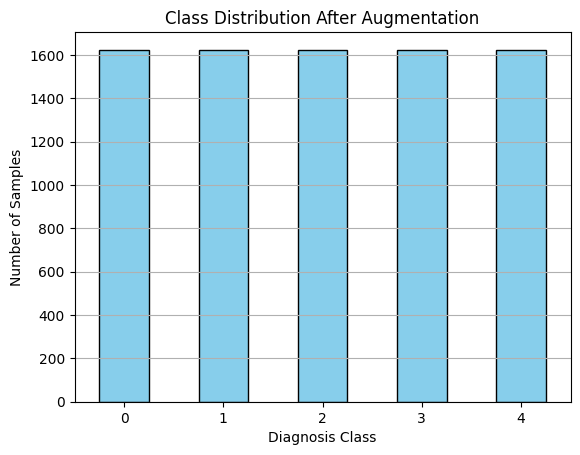

In [7]:
train_split_df['diagnosis'].value_counts().sort_index().plot(kind='bar', color='skyblue', edgecolor='black')
plt.title("Class Distribution After Augmentation")
plt.xlabel("Diagnosis Class")
plt.ylabel("Number of Samples")
plt.xticks(rotation=0)
plt.grid(axis='y')
plt.show()

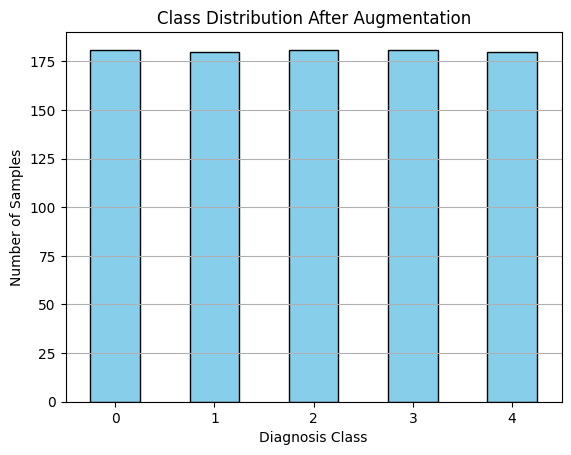

In [8]:
valid_split_df['diagnosis'].value_counts().sort_index().plot(kind='bar', color='skyblue', edgecolor='black')
plt.title("Class Distribution After Augmentation")
plt.xlabel("Diagnosis Class")
plt.ylabel("Number of Samples")
plt.xticks(rotation=0)
plt.grid(axis='y')
plt.show()

In [11]:
from tensorflow.keras.applications import EfficientNetB3
from tensorflow.keras import layers, models

base_model = EfficientNetB3(include_top=False, input_shape=(512, 512, 3), weights='imagenet')
base_model.trainable = False  # For now — will fine-tune later

# Build model
inputs = tf.keras.Input(shape=(512, 512, 3))
x = base_model(inputs, training=False)
x = layers.GlobalAveragePooling2D()(x)
x = layers.Flatten()(x)
x = layers.Dropout(0.3)(x)  
outputs = layers.Dense(5, activation='softmax')(x)

model = tf.keras.Model(inputs, outputs)

# ✅ Add label smoothing here
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    loss=tf.keras.losses.CategoricalCrossentropy(label_smoothing=0.1),
    metrics=['accuracy']
)

model.summary()


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_3 (InputLayer)           │ (None, 512, 512, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ efficientnetb3 (Functional)          │ (None, 16, 16, 1536)        │      10,783,535 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d_1           │ (None, 1536)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 1536)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 1536)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 5)                   │           7,685 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 10,791,220 (41.17 MB)

 Trainable params: 7,685 (30.02 KB)

 Non-trainable params: 10,783,535 (41.14 MB)

In [12]:
os.makedirs("callbacks", exist_ok=True)

early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True, verbose=1)

checkpoint = ModelCheckpoint(
    filepath="callbacks/best_model.keras",
    monitor='val_loss',
    save_best_only=True,
    verbose=1
)

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=2,
    min_lr=1e-6,
    verbose=1
)

callbacks = [early_stop, checkpoint, reduce_lr]
history = model.fit(
    train_flow,
    validation_data=valid_flow,
    epochs=30,
    batch_size=32,
    callbacks=callbacks,
    verbose=1
)


Epoch 1/30
254/254 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.4609 - loss: 1.3381
Epoch 1: val_loss improved from inf to 1.04143, saving model to callbacks/best_model.keras
254/254 ━━━━━━━━━━━━━━━━━━━━ 496s 2s/step - accuracy: 0.4612 - loss: 1.3376 - val_accuracy: 0.6611 - val_loss: 1.0414 - learning_rate: 0.0010
Epoch 2/30
254/254 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.6247 - loss: 1.0818
Epoch 2: val_loss improved from 1.04143 to 1.01150, saving model to callbacks/best_model.keras
254/254 ━━━━━━━━━━━━━━━━━━━━ 424s 2s/step - accuracy: 0.6248 - loss: 1.0818 - val_accuracy: 0.6633 - val_loss: 1.0115 - learning_rate: 0.0010
Epoch 3/30
254/254 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.6530 - loss: 1.0504
Epoch 3: val_loss improved from 1.01150 to 0.97868, saving model to callbacks/best_model.keras
254/254 ━━━━━━━━━━━━━━━━━━━━ 424s 2s/step - accuracy: 0.6530 - loss: 1.0503 - val_accuracy: 0.6988 - val_loss: 0.9787 - learning_rate: 0.0010
Epoch 4/30
254/254 ━━━━━━━━━━━━━━━━━━━

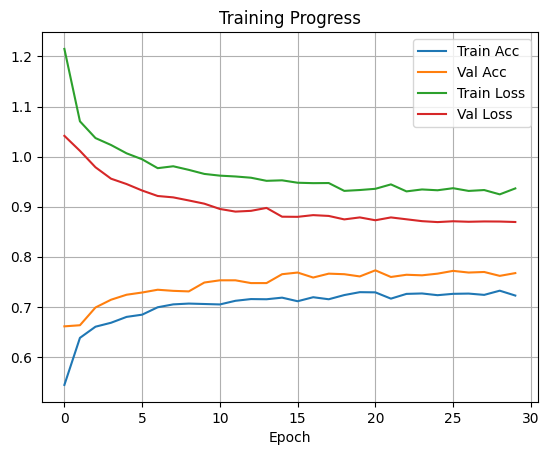

In [13]:
import matplotlib.pyplot as plt

plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title("Training Progress")
plt.xlabel("Epoch")
plt.legend()
plt.grid(True)
plt.show()

In [14]:
model.save("efficientnetb3_retinopathy.h5")

In [17]:
path = "/kaggle/input/aptos2019/"
test_df = pd.read_csv(f"{path}/test.csv")
for df in [test_df]:
    df["diagnosis"] = df["diagnosis"].astype(str)
    df["id_code"] = df["id_code"] + ".png"
print(f"Testing samples: {len(test_df)}")
test_datagen = ImageDataGenerator(
    preprocessing_function=tf.keras.applications.efficientnet.preprocess_input
)
test_flow = test_datagen.flow_from_dataframe(
    dataframe=test_df,
    directory=output_dir,
    x_col="id_code",
    y_col="diagnosis",
    target_size=(img_size, img_size),
    color_mode="rgb",
    class_mode="categorical",
    batch_size=32,
    shuffle=False
)

Testing samples: 366
Found 366 validated image filenames belonging to 5 classes.


In [18]:
loss, acc = model.evaluate(test_flow)
print(f"Test Accuracy: {acc * 100:.2f}%")

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


12/12 ━━━━━━━━━━━━━━━━━━━━ 42s 4s/step - accuracy: 0.8527 - loss: 0.7180
Test Accuracy: 84.70%
